In [67]:
import pandas as pd
import numpy as np
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC

from IPython.display import Image
from sklearn import tree
import pydotplus
import os
from os import system
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import pickle

In [82]:
shows = pd.read_csv('good_shows_data2.csv')

In [10]:
pd.set_option('max_seq_items', 200)

In [11]:
shows.shape

(2515, 168)

In [83]:
## dropping old shows
shows = shows[shows['release_date']>=1980]

In [84]:
## dropping shows where I don't know whether they were cancelled
shows = shows[shows['seasons'] != 0]

In [85]:
shows['release_date'] = shows['release_date'].dropna().apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
shows['release_month'] = shows['release_date'].dropna().apply(lambda x: x.strftime('%m'))
shows['release_month'] = shows['release_month'].dropna().apply(lambda x: int(x))
shows['release_weekday'] = shows['release_date'].dropna().apply(lambda x: x.strftime('%w'))
shows['release_weekday'] = shows['release_weekday'].dropna().apply(lambda x: int(x))

shows['started_sunday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==0 else 0)
shows['started_monday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==1 else 0)
shows['started_tuesday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==2 else 0)
shows['started_wednesday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==3 else 0)
shows['started_thursday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==4 else 0)
shows['started_friday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==5 else 0)
shows['started_saturday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==6 else 0)

In [86]:
shows['started_on_first'] = shows['release_monthday'].dropna().apply(lambda x: 1 if x==1 else 0)

In [15]:
shows.shape

(2061, 168)

In [16]:
shows.columns

Index([u'json', u'title_rough', u'check', u'title', u'imdb_id', u'big_json',
       u'seasons', u'cancelled', u'runtime', u'genres', u'imdb_rating',
       u'release_date', u'plot', u'year', u'type', u'votes', u'keywords',
       u'first_year', u'is_new', u'fixed_runtime', u'is_action',
       u'is_adventure', u'is_animation', u'is_biography', u'is_comedy',
       u'is_crime', u'is_documentary', u'is_drama', u'is_family',
       u'is_fantasy', u'is_game', u'is_history', u'is_horror', u'is_music',
       u'is_musical', u'is_mystery', u'is_news', u'is_reality', u'is_romance',
       u'is_sci', u'is_short', u'is_sport', u'is_talk', u'is_thriller',
       u'is_war', u'is_western', u'release_month', u'release_weekday',
       u'release_monthday', u'stemmed_plot', u'stemmed_keywords',
       u'keyword_adult', u'keyword_african', u'keyword_alien',
       u'keyword_american', u'keyword_angel', u'keyword_anim', u'keyword_base',
       u'keyword_best', u'keyword_black', u'keyword_book', u'keywor

In [17]:
shows.dtypes

json                         object
title_rough                  object
check                         int64
title                        object
imdb_id                      object
big_json                     object
seasons                       int64
cancelled                     int64
runtime                      object
genres                       object
imdb_rating                 float64
release_date         datetime64[ns]
plot                         object
year                         object
type                         object
votes                        object
keywords                     object
first_year                    int64
is_new                        int64
fixed_runtime               float64
is_action                     int64
is_adventure                  int64
is_animation                  int64
is_biography                  int64
is_comedy                     int64
is_crime                      int64
is_documentary                int64
is_drama                    

In [87]:
shows = shows.drop(['json', u'title_rough', u'check', u'title', 'imdb_id', u'big_json',
       u'seasons', 'runtime', u'genres', u'imdb_rating',
       u'release_date', u'plot', u'year', u'type', u'votes', u'keywords', u'is_new', 
        'stemmed_plot', u'stemmed_keywords', 'plot_cleaned', u'network', 'release_month', 'release_weekday', 'fixed_runtime', 'keyword_new'], axis=1)

In [19]:
shows.shape

(2061, 143)

In [20]:
shows.columns

Index([u'cancelled', u'first_year', u'is_action', u'is_adventure',
       u'is_animation', u'is_biography', u'is_comedy', u'is_crime',
       u'is_documentary', u'is_drama', u'is_family', u'is_fantasy', u'is_game',
       u'is_history', u'is_horror', u'is_music', u'is_musical', u'is_mystery',
       u'is_news', u'is_reality', u'is_romance', u'is_sci', u'is_short',
       u'is_sport', u'is_talk', u'is_thriller', u'is_war', u'is_western',
       u'release_monthday', u'keyword_adult', u'keyword_african',
       u'keyword_alien', u'keyword_american', u'keyword_angel',
       u'keyword_anim', u'keyword_base', u'keyword_best', u'keyword_black',
       u'keyword_book', u'keyword_boy', u'keyword_boyfriend',
       u'keyword_brother', u'keyword_california', u'keyword_celebr',
       u'keyword_charact', u'keyword_child', u'keyword_citi',
       u'keyword_comedi', u'keyword_comedian', u'keyword_comic',
       u'keyword_cult', u'keyword_daughter', u'keyword_death',
       u'keyword_detect', u'keyw

In [21]:
shows.shape

(2061, 143)

In [22]:
shows.dropna().shape

(2061, 143)

In [88]:
## defining dependent/independent variables
y = shows['cancelled']
x = shows.drop('cancelled', axis=1)

In [24]:
x.columns

Index([u'first_year', u'is_action', u'is_adventure', u'is_animation',
       u'is_biography', u'is_comedy', u'is_crime', u'is_documentary',
       u'is_drama', u'is_family', u'is_fantasy', u'is_game', u'is_history',
       u'is_horror', u'is_music', u'is_musical', u'is_mystery', u'is_news',
       u'is_reality', u'is_romance', u'is_sci', u'is_short', u'is_sport',
       u'is_talk', u'is_thriller', u'is_war', u'is_western',
       u'release_monthday', u'keyword_adult', u'keyword_african',
       u'keyword_alien', u'keyword_american', u'keyword_angel',
       u'keyword_anim', u'keyword_base', u'keyword_best', u'keyword_black',
       u'keyword_book', u'keyword_boy', u'keyword_boyfriend',
       u'keyword_brother', u'keyword_california', u'keyword_celebr',
       u'keyword_charact', u'keyword_child', u'keyword_citi',
       u'keyword_comedi', u'keyword_comedian', u'keyword_comic',
       u'keyword_cult', u'keyword_daughter', u'keyword_death',
       u'keyword_detect', u'keyword_doctor', u

In [25]:
## Base probability
y.mean()

0.39349830179524503

In [89]:
## train/test split
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [27]:
x_train.shape

(1545, 142)

In [28]:
x_test.shape

(516, 142)

In [29]:
y_train.shape

(1545,)

In [30]:
y_test.shape

(516,)

In [31]:
## runs model
def run_model(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    print "Training set score: ", model.score(x_train, y_train)
    print "Test set score: ", model.score(x_test, y_test)
    predictions = model.predict(x_test)
    print "\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n",classification_report(y_test, predictions)

In [32]:
## plots ROC curve
def plot_roc(x_test, y_test, model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Random Forest

In [42]:
rf = RandomForestClassifier(min_samples_leaf=5)

In [92]:
run_model(x_train, y_train, x_test, y_test, rf)

Training set score:  0.767637540453
Test set score:  0.656976744186

Confusion Matrix:
      predicted_0  predicted_1
is_0          254           60
is_1          117           85

Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.81      0.74       314
          1       0.59      0.42      0.49       202

avg / total       0.65      0.66      0.64       516



In [44]:
rf.predict_proba(x_test)

array([[ 0.7401443 ,  0.2598557 ],
       [ 0.85002914,  0.14997086],
       [ 0.58307736,  0.41692264],
       ..., 
       [ 0.42027825,  0.57972175],
       [ 0.62135925,  0.37864075],
       [ 0.50122186,  0.49877814]])

ROC AUC: 0.69


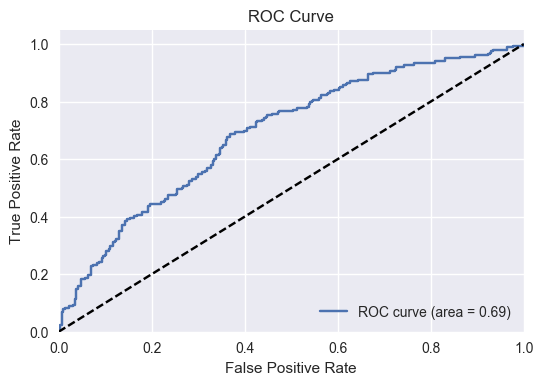

In [93]:
plot_roc(x_test, y_test, rf)

## Random Forest with grid search

In [46]:
parameters = {
    "n_estimators" : [10, 25, 50, 100],
    "max_depth" : [5,7,10,15],
    "max_features" : [0.25, 0.5, 0.75],
    "min_samples_leaf" : [2,3,4,5]
}

In [47]:
gs_rf = RandomForestClassifier()
grid_search = GridSearchCV(gs_rf,param_grid=parameters, cv=7, n_jobs=-1)

In [48]:
## 12:21 - 12:22
grid_search.fit(x_train, y_train)

GridSearchCV(cv=7, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 25, 50, 100], 'max_features': [0.25, 0.5, 0.75], 'max_depth': [5, 7, 10, 15], 'min_samples_leaf': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [49]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.25, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [50]:
run_model(x_train, y_train, x_test, y_test, grid_search.best_estimator_)

Training set score:  0.840776699029
Test set score:  0.687984496124

Confusion Matrix:
      predicted_0  predicted_1
is_0          262           36
is_1          125           93

Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.88      0.76       298
          1       0.72      0.43      0.54       218

avg / total       0.70      0.69      0.67       516



ROC AUC: 0.73


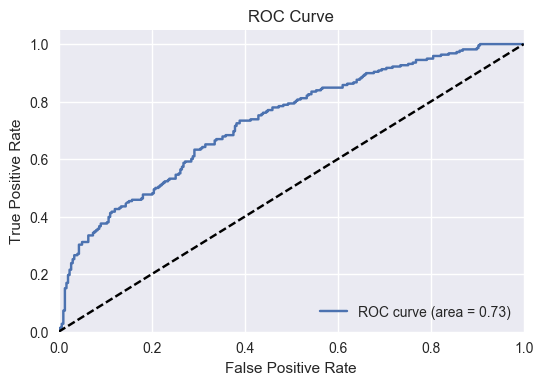

In [51]:
plot_roc(x_test, y_test, grid_search.best_estimator_)

In [52]:
grid_search.best_estimator_.predict_proba(x_test)

array([[ 0.72481831,  0.27518169],
       [ 0.78528649,  0.21471351],
       [ 0.66240564,  0.33759436],
       ..., 
       [ 0.34308213,  0.65691787],
       [ 0.56759615,  0.43240385],
       [ 0.53580001,  0.46419999]])

In [842]:
rf_feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
rf_feature_importances.head(20)

,importance
first_year,0.104360
release_monthday,0.091434
keyword_charact,0.044341
keyword_relationship,0.029965
started_september,0.025797
from_ABC,0.023220
keyword_fiction,0.022120
half_hour,0.020877
keyword_man,0.018225
is_comedy,0.017349


## Decision Tree

In [844]:
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [845]:
## tune hyperparameters here
dt = DecisionTreeClassifier(
    max_depth=15, 
    min_samples_leaf=4,
    max_leaf_nodes=8,
    criterion='gini'
)

In [846]:
run_model(x_train, y_train, x_test, y_test, dt)

Training set score:  0.631067961165
Test set score:  0.606589147287

Confusion Matrix:
      predicted_0  predicted_1
is_0          298           17
is_1          186           15

Classification Report:
             precision    recall  f1-score   support

          0       0.62      0.95      0.75       315
          1       0.47      0.07      0.13       201

avg / total       0.56      0.61      0.51       516



ROC AUC: 0.57


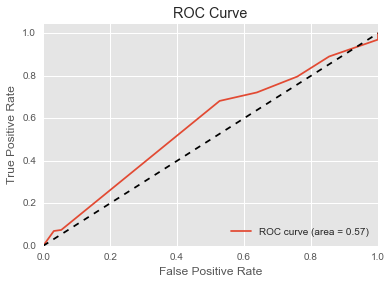

In [847]:
plot_roc(x_test, y_test, dt)

In [848]:
def tune_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    print "Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, new_predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n", classification_report(y_test, new_predictions)
    plt.hist(new_predictions)
    plt.xlabel('New Predictions')
    plt.ylabel('Frequency')
    plt.title('Distribution of New Predictions')
    plt.show()

Confusion Matrix:
      predicted_0  predicted_1
is_0          149          166
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.47      0.56       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.55      0.56       516



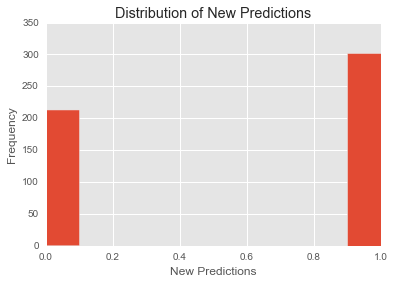

In [849]:
tune_predictions(dt, x_test, y_test, .30)

Confusion Matrix:
      predicted_0  predicted_1
is_0          305           10
is_1          187           14

Classification Report:
             precision    recall  f1-score   support

          0       0.62      0.97      0.76       315
          1       0.58      0.07      0.12       201

avg / total       0.61      0.62      0.51       516



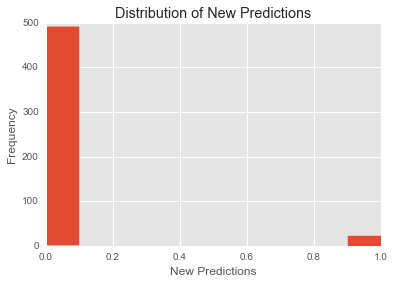

In [850]:
tune_predictions(dt, x_test, y_test, .60)

In [851]:
## plots the distribution of prediction probabilities for the 1 class
def plot_proba(x_test, model):
    predict = model.predict_proba(x_test)
    plt.hist(predict[:,1], bins=40)
    plt.ylabel('Frequency')
    plt.xlabel('Class 1 Probability Cutoff')
    plt.show()

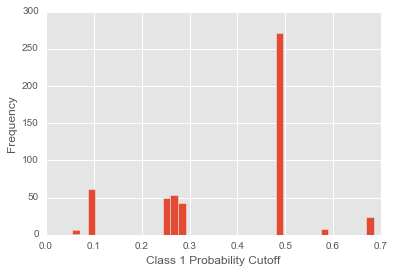

In [852]:
plot_proba(x_test, dt)

(array([   7.,    0.,  200.,   17.,   17.,  186.,    0.,    0.,    0.,   89.]),
 array([ 0.125     ,  0.17825342,  0.23150685,  0.28476027,  0.3380137 ,
         0.39126712,  0.44452055,  0.49777397,  0.5510274 ,  0.60428082,
         0.65753425]),
 <a list of 10 Patch objects>)

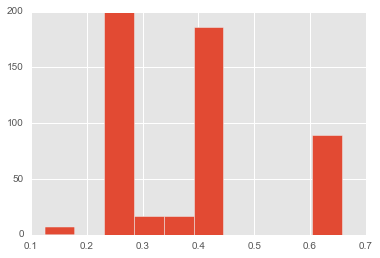

In [853]:
plt.hist(predict[:,1])

([array([   0.,    0.,   89.,    0.,    0.,  186.,   17.,   61.,  156.,    7.]),
  array([   7.,  156.,   61.,   17.,  186.,    0.,    0.,   89.,    0.,    0.])],
 array([ 0.125,  0.2  ,  0.275,  0.35 ,  0.425,  0.5  ,  0.575,  0.65 ,
         0.725,  0.8  ,  0.875]),
 <a list of 2 Lists of Patches objects>)

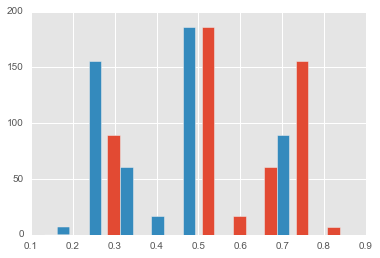

In [854]:
plt.hist(predict)

(array([ 427.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   89.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

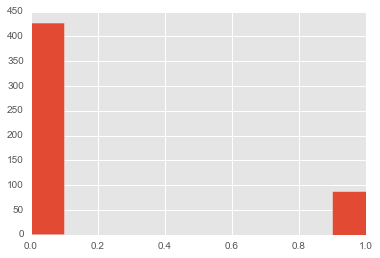

In [855]:
plt.hist(predictions_60)

In [856]:
predictions_60

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,


In [857]:
confusion_matrix(y_test, predictions_60)

array([[253,  62],
       [174,  27]])

Confusion Matrix:
      predicted_0  predicted_1
is_0          149          166
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.47      0.56       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.55      0.56       516



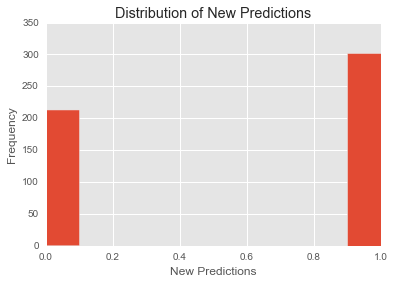

In [858]:
tune_predictions(dt, x_test, y_test, .30)

Confusion Matrix:
      predicted_0  predicted_1
is_0          149          166
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.47      0.56       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.55      0.56       516



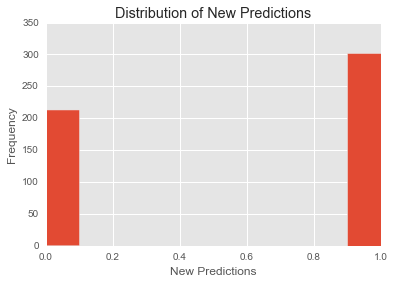

In [859]:
tune_predictions(dt, x_test, y_test, .40)

## grid-searching the decision tree

In [860]:
dt_for_gs = DecisionTreeClassifier()

In [861]:
params_dt = {
    "max_depth":[10,15,20],
    "min_samples_leaf":[2,3,4,5],
    "max_leaf_nodes":[4,6,8,10],
    "criterion":['gini', 'entropy']
}

In [862]:
gs_dt = GridSearchCV(dt_for_gs, params_dt)

In [863]:
gs_dt.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [4, 6, 8, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20], 'min_samples_leaf': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [864]:
gs_dt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=10, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [865]:
run_model(x_train, y_train, x_test, y_test, gs_dt.best_estimator_)

Training set score:  0.649190938511
Test set score:  0.624031007752

Confusion Matrix:
      predicted_0  predicted_1
is_0          293           22
is_1          172           29

Classification Report:
             precision    recall  f1-score   support

          0       0.63      0.93      0.75       315
          1       0.57      0.14      0.23       201

avg / total       0.61      0.62      0.55       516



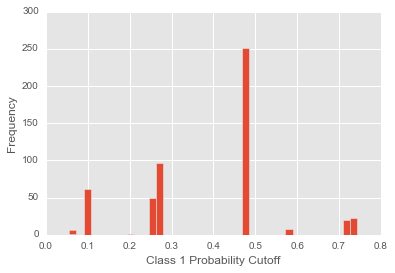

In [866]:
## in the original model, the false negatives were higher than the true positives. This is terrible, and needs fixing.


plot_proba(x_test, gs_dt.best_estimator_)

Confusion Matrix:
      predicted_0  predicted_1
is_0          150          165
is_1           64          137

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.48      0.57       315
          1       0.45      0.68      0.54       201

avg / total       0.60      0.56      0.56       516



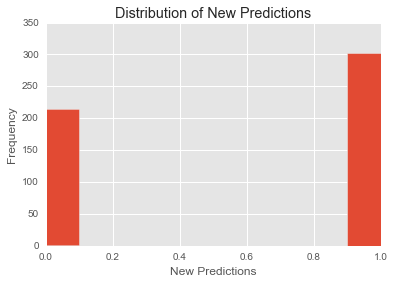

In [867]:
## with probability=0.4, model score is 0.62. the false negatives are down, but the false positives are up.
tune_predictions(gs_dt, x_test, y_test, .40)

In [868]:
confusion_matrix(y_test, predictions_60)

array([[253,  62],
       [174,  27]])

In [869]:
cmatrix = confusion_matrix(y_test, predictions_60)

In [870]:
cmatrix[0,0]

253

In [871]:
def get_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    return new_predictions

In [872]:
def find_optimal_probability(model, x_test, y_test):
    probabilities = range(1,101)
    new_probabilities = []
    for i in probabilities:
        new_probabilities.append(float(i)/100)
    range_of_scores = []
    for i in new_probabilities:
        new_preds = get_predictions(model, x_test, y_test, i)
        cmatrix = confusion_matrix(y_test, new_preds)
        new_model_score = (cmatrix[0,0] + cmatrix[1,1])/float(np.sum(cmatrix))
        range_of_scores.append(new_model_score)
    
    plt.plot(new_probabilities, range_of_scores)
    plt.title("Model Scores at Different Cutoff Probabilities")
    plt.xlabel("Probability Cutoff")
    plt.ylabel("Model Score")
    plt.show()

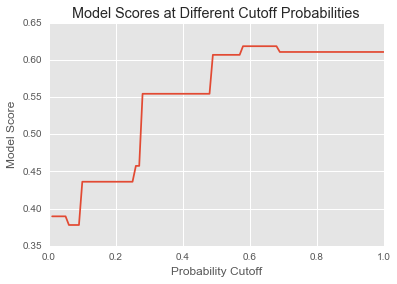

In [873]:
find_optimal_probability(dt, x_test, y_test)

## Gradient Boosting

In [54]:
GradientBoostingClassifier()

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [55]:
boost_default = GradientBoostingClassifier()

In [56]:
boost = GradientBoostingClassifier(
    n_estimators=500, 
    max_depth= 6,
    learning_rate= 0.1, 
    min_samples_leaf=2
    )

In [94]:
run_model(x_train, y_train, x_test, y_test, boost)

Training set score:  0.999352750809
Test set score:  0.68992248062

Confusion Matrix:
      predicted_0  predicted_1
is_0          245           69
is_1           91          111

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.78      0.75       314
          1       0.62      0.55      0.58       202

avg / total       0.69      0.69      0.69       516



In [95]:
run_model(x_train, y_train, x_test, y_test, boost_default)

Training set score:  0.803883495146
Test set score:  0.670542635659

Confusion Matrix:
      predicted_0  predicted_1
is_0          252           62
is_1          108           94

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.80      0.75       314
          1       0.60      0.47      0.53       202

avg / total       0.66      0.67      0.66       516



In [880]:
boost_feature_importances = pd.DataFrame(boost_default.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
boost_feature_importances.head(20)

,importance
first_year,0.124028
release_monthday,0.068787
from_ABC,0.035520
keyword_charact,0.034160
is_documentary,0.021511
keyword_fiction,0.021280
started_september,0.021012
keyword_friend,0.020070
keyword_cult,0.018948
full_hour,0.018384


# XGBoost

In [59]:
xgb = XGBClassifier()

In [96]:
run_model(x_train, y_train, x_test, y_test, xgb)

Training set score:  0.794822006472
Test set score:  0.674418604651

Confusion Matrix:
      predicted_0  predicted_1
is_0          254           60
is_1          108           94

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.81      0.75       314
          1       0.61      0.47      0.53       202

avg / total       0.67      0.67      0.66       516



## ADA Boosting

In [107]:
rfc = RandomForestClassifier(min_samples_leaf=4)

In [101]:
ada_default = AdaBoostClassifier()

In [111]:
ada = AdaBoostClassifier(base_estimator=rfc, n_estimators=100)

In [61]:
ada_boost = AdaBoostClassifier(n_estimators=100)

In [103]:
ada_default

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [109]:
run_model(x_train, y_train, x_test, y_test, ada_default)

Training set score:  0.730097087379
Test set score:  0.662790697674

Confusion Matrix:
      predicted_0  predicted_1
is_0          240           74
is_1          100          102

Classification Report:
             precision    recall  f1-score   support

          0       0.71      0.76      0.73       314
          1       0.58      0.50      0.54       202

avg / total       0.66      0.66      0.66       516



In [112]:
run_model(x_train, y_train, x_test, y_test, ada)

Training set score:  0.999352750809
Test set score:  0.668604651163

Confusion Matrix:
      predicted_0  predicted_1
is_0          248           66
is_1          105           97

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.79      0.74       314
          1       0.60      0.48      0.53       202

avg / total       0.66      0.67      0.66       516



In [99]:
run_model(x_train, y_train, x_test, y_test, ada_boost)

Training set score:  0.736569579288
Test set score:  0.676356589147

Confusion Matrix:
      predicted_0  predicted_1
is_0          243           71
is_1           96          106

Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.77      0.74       314
          1       0.60      0.52      0.56       202

avg / total       0.67      0.68      0.67       516



In [113]:
ada_boost.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [114]:
ada_boost.score(x_train, y_train)

0.73656957928802591

In [115]:
ada_boost.score(x_test, y_test)

0.6763565891472868

## pickling adaboost

In [ ]:
ada_boost_pickle_path = 'ada_boost_pickle.pkl'
ada_boost_pickle = open(ada_boost_pickle_path, 'wb')
pickle.dump(numbers_list, list_pickle)
list_pickle.close()

ROC AUC: 0.70


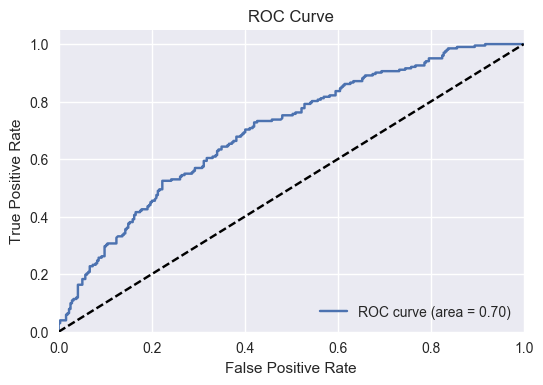

In [100]:
plot_roc(x_test, y_test, ada_boost)

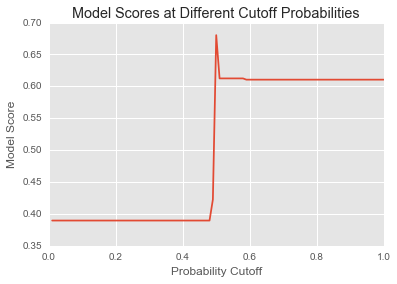

In [885]:
find_optimal_probability(ada_boost, x_test, y_test)

In [65]:
adaboost_feature_importances = pd.DataFrame(ada_boost.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
adaboost_feature_importances.head(20)

,importance
first_year,0.13
half_hour,0.03
release_monthday,0.03
is_reality,0.02
from_ABC,0.02
keyword_relationship,0.02
keyword_girl,0.02
keyword_death,0.02
keyword_charact,0.02
full_hour,0.02


## Decision tree for show

In [887]:
## this will create a single decision tree from the whole dataset that is readable by humans. 
## for display purposes only. it will be tuned to have approximately the same score as the AdaBoost model

dt_for_show = DecisionTreeClassifier(
                    max_depth=7,
                    min_samples_leaf=5,
#                     max_leaf_nodes=10
#     class_weight=None, criterion='gini', max_depth=10,
#             max_features=None, max_leaf_nodes=10, min_samples_leaf=2,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             presort=False, random_state=None, splitter='best'
)

In [888]:
dt_for_show.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [889]:
dt_for_show.score(x,y)

0.69820475497331391

In [890]:
## exporting decision tree to png

dtree = dt_for_show.fit(x, y)

dotfile = open("dtree2.dot", 'w')
tree.export_graphviz(dtree, 
                     out_file = dotfile, 
                     feature_names = x.columns, 
                     class_names=['renewed', 'cancelled'],  
                     filled=True, 
                     rounded=True,
                     special_characters=True,
                     impurity=False,
                     label='none'
                    )
dotfile.close()

system('dot -Tpng dtree2.dot -o dtree2.png')

0

In [891]:
dt_show_feature_importances = pd.DataFrame(dt_for_show.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
dt_show_feature_importances.head(20)

,importance
keyword_relationship,0.148957
release_monthday,0.099691
keyword_charact,0.080150
keyword_fiction,0.070069
started_september,0.070020
half_hour,0.049042
is_comedy,0.042127
first_year,0.040699
keyword_cult,0.030586
started_sunday,0.028156


## Logistic regression

In [77]:
lr = LogisticRegression()

In [78]:
run_model(x_train, y_train, x_test, y_test, lr)

Training set score:  0.732686084142
Test set score:  0.68023255814

Confusion Matrix:
      predicted_0  predicted_1
is_0          239           59
is_1          106          112

Classification Report:
             precision    recall  f1-score   support

          0       0.69      0.80      0.74       298
          1       0.65      0.51      0.58       218

avg / total       0.68      0.68      0.67       516



In [894]:
coefficients = lr.coef_

In [895]:
coefficients[:,1]

array([-0.04140225])

In [896]:
x.columns[0]

'first_year'

In [897]:
zip(x.columns, coefficients[0])

[('first_year', 0.00040729768503373789),
 ('is_action', -0.04140224700450304),
 ('is_adventure', 0.10050973059922792),
 ('is_animation', -0.68682640953826768),
 ('is_biography', 0.18950135740757371),
 ('is_comedy', 0.048066003849153376),
 ('is_crime', -0.48580813535638456),
 ('is_documentary', -1.0072959273252255),
 ('is_drama', 0.13796202920031395),
 ('is_family', -0.38326177114638488),
 ('is_fantasy', -0.23577153410982282),
 ('is_game', -1.0575812714994706),
 ('is_history', -0.040687256182800995),
 ('is_horror', 0.011381754802275049),
 ('is_music', -0.20565156497266859),
 ('is_musical', -0.086836697828643686),
 ('is_mystery', -0.79724998371177935),
 ('is_news', -0.46647666961019468),
 ('is_reality', -0.59091199494758229),
 ('is_romance', -0.80816985998865731),
 ('is_sci', 0.21013906120910508),
 ('is_short', 0.0),
 ('is_sport', -0.24890147923938727),
 ('is_talk', -1.00898152958582),
 ('is_thriller', 0.1410874635872722),
 ('is_war', -0.068318840862162403),
 ('is_western', 0.19041145974

In [898]:
x['started_saturday'].sum()

259

In [942]:
x.shape

(2061, 142)

In [945]:
y.value_counts()

0    1250
1     811
Name: cancelled, dtype: int64

# Support Vector Machines

In [68]:
svc = SVC(verbose=True)
nusvc = NuSVC()
linsvc = LinearSVC()

In [69]:
run_model(x_train, y_train, x_test, y_test, svc)

[LibSVM]Training set score:  0.638187702265
Test set score:  0.577519379845

Confusion Matrix:
      predicted_0  predicted_1
is_0          293            5
is_1          213            5

Classification Report:
             precision    recall  f1-score   support

          0       0.58      0.98      0.73       298
          1       0.50      0.02      0.04       218

avg / total       0.55      0.58      0.44       516



In [76]:
run_model(x_train, y_train, x_test, y_test, nusvc)

Training set score:  0.90355987055
Test set score:  0.668604651163

Confusion Matrix:
      predicted_0  predicted_1
is_0          238           60
is_1          111          107

Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.80      0.74       298
          1       0.64      0.49      0.56       218

avg / total       0.66      0.67      0.66       516



In [75]:
run_model(x_train, y_train, x_test, y_test, linsvc)

Training set score:  0.383818770227
Test set score:  0.422480620155

Confusion Matrix:
      predicted_0  predicted_1
is_0            0          298
is_1            0          218

Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       298
          1       0.42      1.00      0.59       218

avg / total       0.18      0.42      0.25       516

